In [1]:
%matplotlib ipympl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LightSource

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

In [3]:
N = 5000
D = 101
betas_res = 30
gammas_res = 30

In [4]:
p = np.arange(0,D,1)
sqrt2 = np.sqrt(2)
w = 2*np.pi/D
im = complex(0.0,1.0)
U = np.zeros((D,2,2),np.complex128)
# For convinience, operate in p basis
instate = np.zeros((D,2,2),np.complex128)
instate[0,0,0] = 0.5
instate[0,1,0] = 0.5*im
instate[0,0,1] = 0.5*im
instate[0,1,1] = - 0.5
pstate = np.zeros((D,2,2),np.complex128)
finstate = np.zeros((D,2,2),np.complex128)
transf = np.zeros((D,D),np.complex128)
omegap = np.exp(im*w*p)
omegam = np.exp(-im*w*p)
omegasigma = np.zeros(D,np.matrix)
for m in p:
    omegasigma[m] = np.matrix([[np.exp(im*w*m),0],[0,np.exp(-im*w*m)]],dtype=np.complex128)

times = np.arange(0,N,1)
transf = omegap[:,None]**p/np.sqrt(D)
identities = np.tile(np.eye(2,dtype=np.complex128),(N,D,1,1))
q1_inters = (times%2 == 0)
q2_inters = (q1_inters == 0)
powers = np.arange(0,N/2,1)
# np.multiply(1/np.sqrt(D),transf,out=transf)
np.einsum('pq,qmn -> pmn',transf,instate,out=pstate)
n_qubits = 2
qubitstate_size = 2**n_qubits


In [5]:
print(powers.shape)
print(U[0])

(2500,)
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


In [6]:
def array_to_order(array, order):
    arr = np.matrix(array)
    rows, cols = arr.shape
    # Create 3D empty array where the middle dimension is
    # the array at powers 0 through order
    out = np.empty((order + 1, rows, cols), dtype=arr.dtype)
    out[0, :, :] = 1   # 0th power is always 1
    a = np.broadcast_to(arr[None,:,:], (order, rows, cols))
    # Cumulatively multiply arrays so each multiplication produces the next order
    np.cumprod(a, axis=0, out=out[1:,:,:])
    return out.reshape((order+1,rows,cols))[1:,:,:]

In [7]:
betas = np.linspace(0,np.pi/2,betas_res)
gammas = np.linspace(0,2*np.pi,gammas_res)
averages = np.zeros((betas_res,gammas_res),float)
Upowers = np.zeros((D,round(N/2),2,2),np.complex128)
b = 0
coin = np.matrix([[1,0],[0,1]],dtype=np.complex128)
for beta in betas:
    cos = np.cos(beta/2)
    sin = np.sin(beta/2)
    g = 0
    for gamma in gammas:
        gamma_phase = np.exp(im*gamma)
        U[:,0,0] = cos * omegap # [0] representa |0> y [1] |1>
        U[:,0,1] = - gamma_phase * sin * omegap
        U[:,1,0] = sin * omegam
        U[:,1,1] = gamma_phase * cos * omegam
        for m in p:
            Upowers[m,...] = array_to_order(U[m,...],round(N/2))
        concurrences = np.zeros(N,float)
        j = 0
        U1 = identities.copy()
        U2 = identities.copy()
        U1[q1_inters,:,:,:] = Upowers.swapaxes(0,1)
        U2[q2_inters,:,:,:] = Upowers.swapaxes(0,1)

        pevolved_state = np.einsum("tpij,tpkl,pjl->tpik",U1,U2,pstate)
        evolved_state = np.einsum('qp,tpik->tqik',np.conj(transf),pevolved_state)
        concurrences = np.sum(2*np.absolute(evolved_state[...,0,0] * evolved_state[...,1,1] - evolved_state[...,0,1] * evolved_state[...,1,0]),axis=1)
        j += 1
        averages[b,g] = np.average(concurrences)
        g +=1
    b += 1

(2500, 2, 2)


In [8]:
print(Upowers.shape)

(101, 2500, 2, 2)


Text(0, 0.5, '$\\bar{C}(\\beta)$')

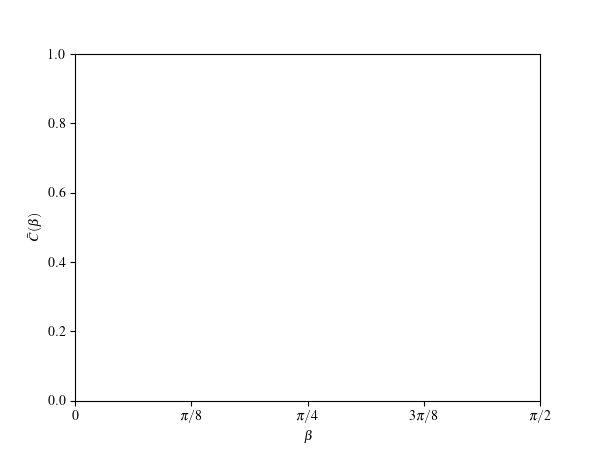

In [9]:
fig = plt.figure(figsize=(6,4.5))
fig.clear()
ax = fig.subplots()
ax.plot(betas,averages,'k-', lw=0.5)
ax.set_xlim(0,np.pi/2)
ax.set_xticks([0,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2],[0,r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])
# ax.set_xticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],[0,r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
ax.set_xlabel(r'$\beta$')
ax.set_ylim(0,1)
ax.set_ylabel(r'$\bar{C}(\beta)$')
# ax.plot((0,N),(avg,avg),'--', label = r'$\bar{C} \approx $' + str(avg)[:6],lw=2,color="darkred")
# ax.legend(loc='upper right')

Text(0, 35, '(b)')

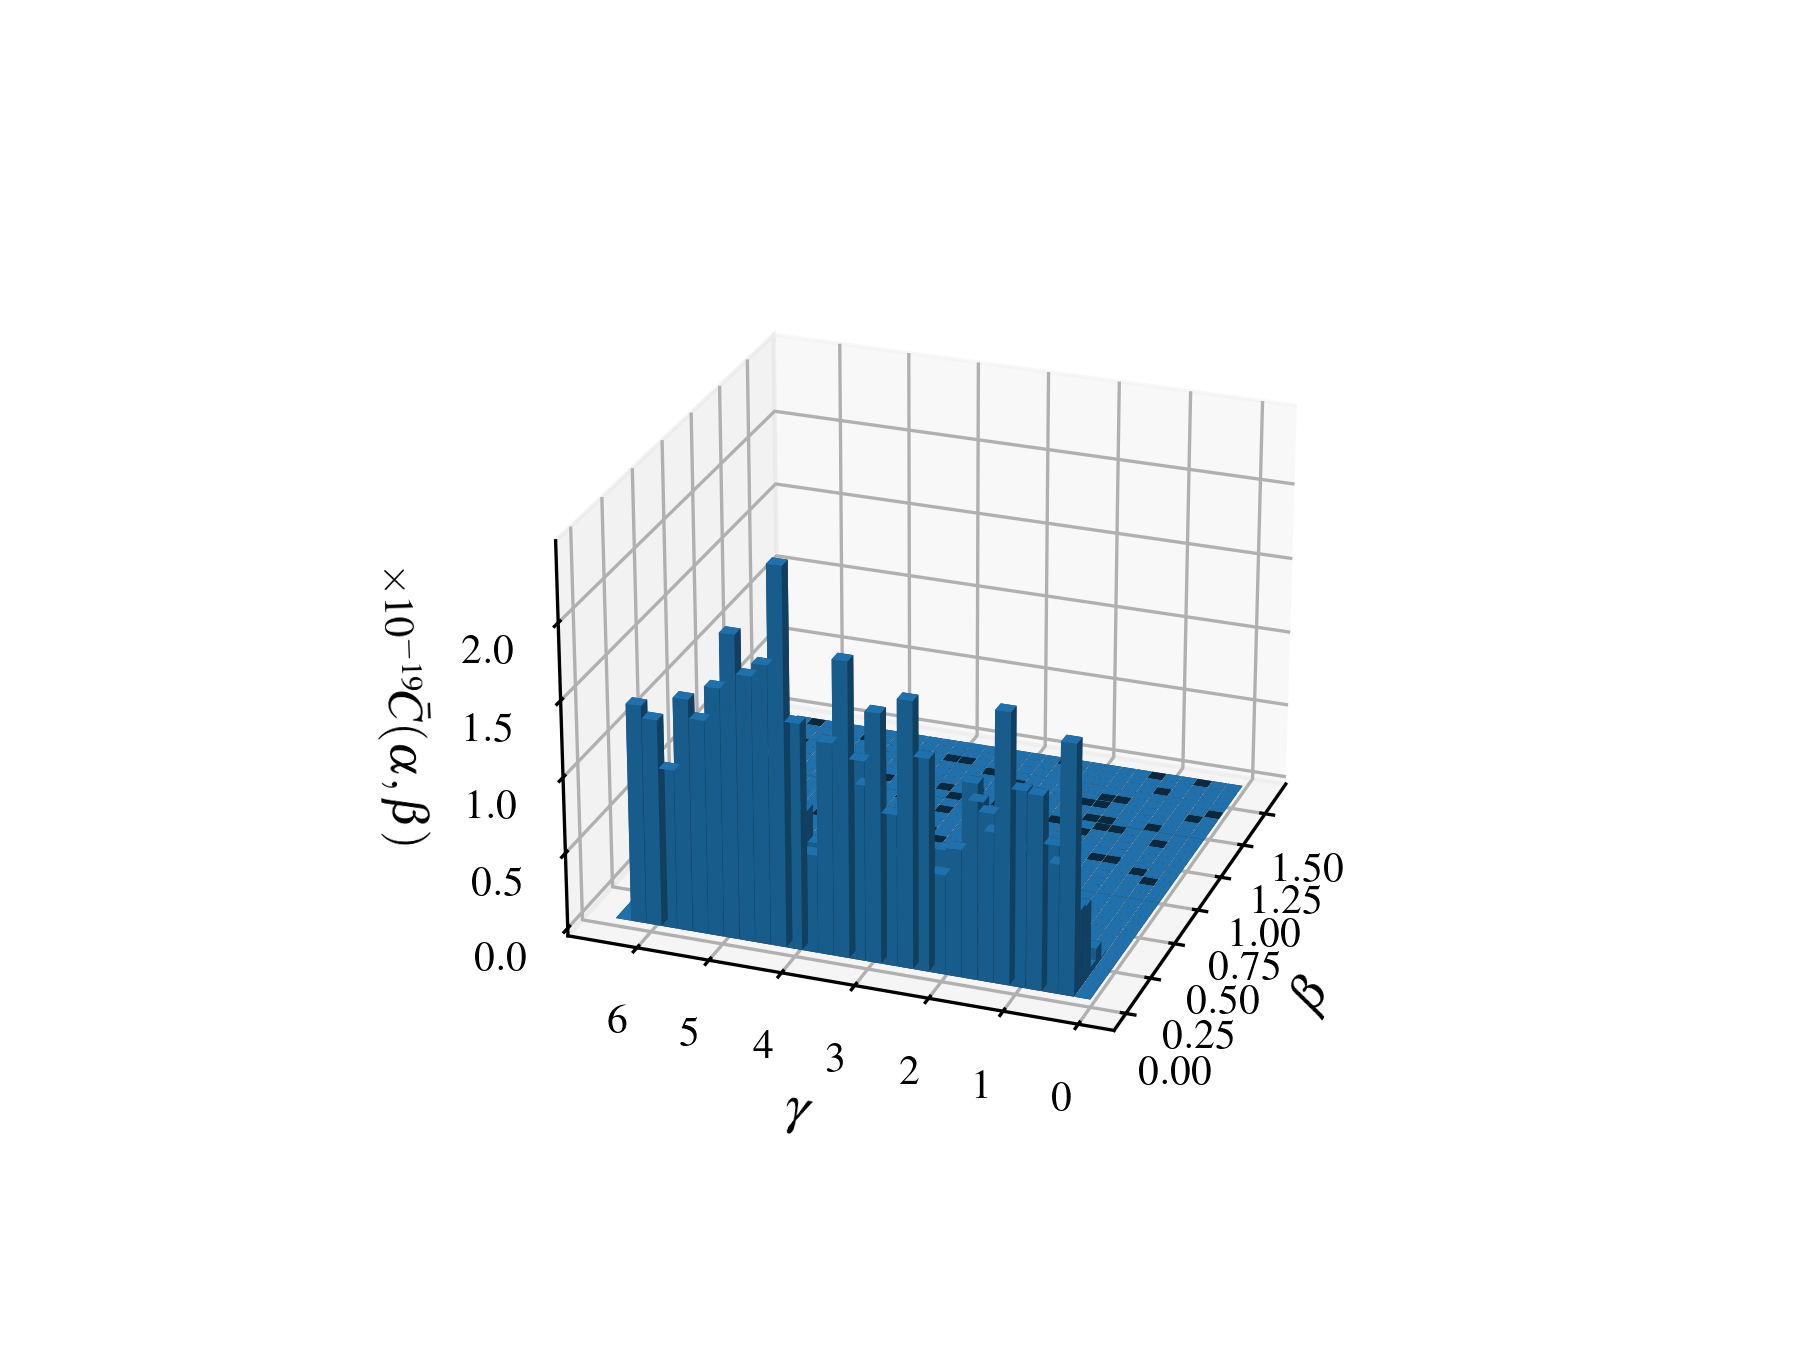

In [10]:
_xx, _yy = np.meshgrid(betas, gammas)
x, y = _xx.ravel(), _yy.ravel()
width = np.max(betas)/betas_res
depth = np.max(gammas)/gammas_res
light = LightSource(azdeg=315,altdeg=60)
fig = plt.figure(figsize=(6,4.5),dpi=300)
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=25,azim=-160,roll=0)
ax.set_xlabel(r'$\beta$',fontsize=12)
ax.set_ylabel(r'$\gamma$',fontsize=12)
ax.set_zlabel(r'$\bar{C}(\beta,\gamma)$',fontsize=12)
ax.set_box_aspect(None, zoom=0.85)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 5
ax.zaxis.labelpad = 5
ax.bar3d(x,y,0,width,depth,averages.flatten('F'),lightsource=light)